# Information

This notebook contains the data analyses for the MSc thesis 'An Approach for Ecologists to Estimate Causal Effects from Observational Data' by Midas Siahaya.

Date: 10 July 2025

# Libraries

### General libraries

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import graphviz as gr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import dowhy
from dowhy import CausalModel

# Simulation 1


Simulation 1 is a simulation of System 1 (see the graph). All functions are linear. This simulation shows what the effect of confounding can be. The first OLS estimation does not adjust the confounder C, but the second OLS estimation does. The simulation is iterated a 1000 times and a density plot with both estimation distributions is plotted.

- Direct effect = 3 (also the total causal effect, because there are no indirect paths)
- Unadjusted effect = 3.5 (see Appendix 1 of the report for an analytical validation)

### Causal graph System 1

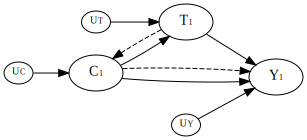

In [ ]:
g = gr.Digraph()

g.attr(rankdir='LR')

# Solid edges
g.edge("T", "Y")
g.edge("C", "T")
g.edge("C", "Y")

# Dashed parallel edges
g.edge("T", "C", style="dashed", constraint="false")
g.edge("C", "Y", style="dashed", constraint="false")

# U edges
g.edge("uy", "Y")
g.edge("ut", "T")
g.edge("uc", "C")

# U nodes and subscripts
g.node("uy", label='<U<sub><font point-size="8">Y</font></sub>>', width='0.4', height='0.3', fontsize='10', shape='ellipse', fixedsize='true')
g.node("ut", label='<U<sub><font point-size="8">T</font></sub>>', width='0.4', height='0.3', fontsize='10', shape='ellipse', fixedsize='true')
g.node("uc", label='<U<sub><font point-size="8">C</font></sub>>', width='0.4', height='0.3', fontsize='10', shape='ellipse', fixedsize='true')

g.node("Y", label='<Y<sub><font point-size="8">1</font></sub>>')
g.node("T", label='<T<sub><font point-size="8">1</font></sub>>')
g.node("C", label='<C<sub><font point-size="8">1</font></sub>>')

g


Save DAG System 1 as SVG file to the environment. From there it can be downloaded.

In [ ]:
g.render('system_1', format='svg', cleanup=True)

'system_1.svg'

### Estimations System 1

Initiate parameters

In [ ]:
n = 1000
iterations = 1000

direct_causal_effect = 3
unadjusted_effect = 3.5

Lists are initiated. In a `for loop`, the data is generated (`n` samples) and OLS estimations are performed `iterations` times. Mean estimated coefficients are prited and Kernal Density Estimations (KDE) are performed for visualizing the coefficient data.   

In [ ]:
# Initiate lists
coeffs_total = []
coeffs_unadjusted = []

# Loop data generation and OLS estimation
for _ in range(iterations):

  # Data generation (exogenous variables)
  C = np.random.rand(n)

  # Data generation (endogenous variables)
  T = 1*C + np.random.normal(0, 0.5, n)
  Y = direct_causal_effect*T + 2*C + np.random.normal(0, 0.5, n)

  # Compile DataFrame
  df = pd.DataFrame({'C': C, 'T': T, 'Y': Y})

  # OLS estimations
  Z_unadjusted = sm.add_constant(df[['T']])
  model_unadjusted = sm.OLS(df['Y'], Z_unadjusted).fit()
  coeffs_unadjusted.append(model_unadjusted.params['T']) # Save estimated coefficient to list

  Z_total = sm.add_constant(df[['T', 'C']])
  model_total = sm.OLS(df['Y'], Z_total).fit()
  coeffs_total.append(model_total.params['T']) # Save estimated coefficient to list

# Print mean of estiamtions
print(f'Estimated total effect: {np.mean(coeffs_total):.3f} sdev: {np.std(coeffs_total):.3f}','\n')
print(f'Estimated unadjusted effect: {np.mean(coeffs_unadjusted):.3f} sdev: {np.std(coeffs_total):.3f}','\n')

# Estimate kernel densities (KDE)
kde_total = gaussian_kde(coeffs_total)
kde_unadjusted = gaussian_kde(coeffs_unadjusted)

# Calculate mean estimated coefficient
mean_total = np.mean(coeffs_total)
mean_unadjusted = np.mean(coeffs_unadjusted)

# Get density height at mean estimated coefficient
height_total = kde_total(mean_total)
height_unadjusted = kde_unadjusted(mean_unadjusted)


Estimated total effect: 3.000 sdev: 0.031 

Estimated unadjusted effect: 3.501 sdev: 0.031 



KDEs of System 1 are plotted and saved to SVG file format.



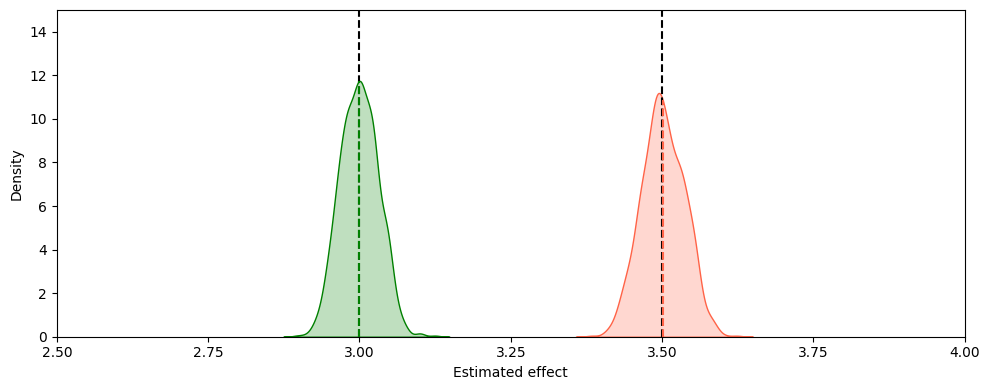

In [ ]:
plt.figure(figsize=(10, 4))

# Add lines for validated effects
plt.axvline(unadjusted_effect, color="black", linestyle="--", label="Unadjusted effect")
plt.axvline(direct_causal_effect, color="black", linestyle="--", label="Total effect")

# Plot densities
sns.kdeplot(coeffs_unadjusted, label="Unadjusted", fill=True, color="tomato")
plt.vlines(mean_unadjusted, 0, height_unadjusted, colors="tomato", linestyles="--", label="Mean unadjusted")

sns.kdeplot(coeffs_total, label="Total", fill=True, color="green")
plt.vlines(mean_total, 0, height_total, colors="green", linestyles="--", label="Mean total")

# Layout
plt.ylim(0, 15)
plt.xlim(2.5, 4)
plt.xticks(np.arange(2.5, 4.25, 0.25))
plt.xlabel("Estimated effect")
plt.ylabel("Density")
# plt.legend()
plt.tight_layout()

plt.savefig("estimations_sys_1.svg")


# Simulation 2

Simulation 2 is a simulation of System 2 (see the graph). All functions are linear. This simulation shows the difference between the direct effect, the total causal effect, and the unadjusted effect. The first OLS estimation does not adjust the confounder C and mediator X. The second OLS estimation adjusts both confounder C and mediator M, resulting in the direct effect estiamtion. The third OLS estimation only adjusts C, resulting in an unbiased estimation of the total causal effect (the one ecologists are often after). The simulation is iterated a 1000 times and a density plot with all three estimation distributions is plotted.

- Total causal effect = 11 (see report)
- Direct effect = 3
- Unadjusted effect = 12.25 (see Appendix 2 of the report for an analytical validation)

### Causal graph System 2

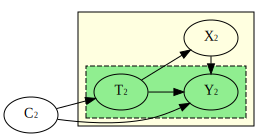

In [14]:
g = gr.Digraph()
g.attr(rankdir='LR')

# Outer cluster that includes inner cluster + X
with g.subgraph(name='cluster_outer') as outer:
    outer.attr(
        style='filled',
        color='black',
        fillcolor='lightyellow'
    )

    # Inner cluster with T and Y
    with outer.subgraph(name='cluster_TY') as inner:
        inner.attr(
            style='filled,dashed',
            color='black',
            fillcolor='lightgreen'
        )
        inner.node('T', label='<T<sub><font point-size="8">2</font></sub>>')
        inner.node('Y', label='<Y<sub><font point-size="8">2</font></sub>>')

    # X is part of the outer cluster but not the inner
    outer.node('X', label='<X<sub><font point-size="8">2</font></sub>>')

# Add other nodes and edges
g.edge("T", "Y")
g.edge("T", "X")
g.edge("X", "Y")
g.edge("C", "T")
g.edge("C", "Y")

g.node("C", label='<C<sub><font point-size="8">2</font></sub>>')

g


Save DAG System 2 as SVG file to the environment. From there it can be downloaded.

In [15]:
g.render('system_2', format='svg', cleanup=True)

'system_2.svg'

### Estimations System 2

Initiate parameters

In [16]:
n = 1000
iterations = 1000

total_causal_effect = 11
direct_causal_effect = 3
unadjusted_effect = 12.25

Lists are initiated. In a `for loop`, the data is generated (`n` samples) and OLS estimations are performed `iterations` times. Mean estimated coefficients are prited and Kernal Density Estimations (KDE) are performed for visualizing the coefficient data.   

In [17]:
# Initiate lists
coeffs_total = []
coeffs_direct = []
coeffs_unadjusted = []

# Loop data generation and OLS estimation
for _ in range(iterations):

  # Data generation (exogenous variables)
  C = np.random.rand(n)

  # Data generation (endogenous variables)
  T = 1*C + np.random.normal(0, 0.5, n)
  X = 2*T + np.random.normal(0, 0.5, n)
  Y = direct_causal_effect*T + 4*X + 5*C + np.random.normal(0, 0.5, n)

  # Compile DataFrame
  df = pd.DataFrame({'C': C, 'T': T, 'X': X, 'Y': Y})

  # OLS estimations
  Z_unadjusted = sm.add_constant(df[['T']])
  model_unadjusted = sm.OLS(df['Y'], Z_unadjusted).fit()
  coeffs_unadjusted.append(model_unadjusted.params['T']) # Save estimated coefficient to list

  Z_direct = sm.add_constant(df[['T', 'X', 'C']])
  model_direct = sm.OLS(df['Y'], Z_direct).fit()
  coeffs_direct.append(model_direct.params['T']) # Save estimated coefficient to list

  Z_total = sm.add_constant(df[['T', 'C']])
  model_total = sm.OLS(df['Y'], Z_total).fit()
  coeffs_total.append(model_total.params['T']) # Save estimated coefficient to list

# Print mean of estiamtions
print(f'Estimated total effect: {np.mean(coeffs_total):.3f} sdev: {np.std(coeffs_total):.3f}','\n')
print(f'Estimated direct effect: {np.mean(coeffs_direct):.3f} sdev: {np.std(coeffs_direct):.3f}','\n')
print(f'Estimated unadjusted effect: {np.mean(coeffs_unadjusted):.3f} sdev: {np.std(coeffs_unadjusted):.3f}','\n')

# Estimate kernel densities (KDE)
kde_total = gaussian_kde(coeffs_total)
kde_direct = gaussian_kde(coeffs_direct)
kde_unadjusted = gaussian_kde(coeffs_unadjusted)

# Calculate mean estimated coefficient
mean_total = np.mean(coeffs_total)
mean_direct = np.mean(coeffs_direct)
mean_unadjusted = np.mean(coeffs_unadjusted)

# Get density height at mean estimated coefficient
height_total = kde_total(mean_total)
height_direct = kde_direct(mean_direct)
height_unadjusted = kde_unadjusted(mean_unadjusted)


Estimated total effect: 11.009 sdev: 0.137 

Estimated direct effect: 3.004 sdev: 0.071 

Estimated unadjusted effect: 12.258 sdev: 0.132 



KDEs of System 2 are plotted and saved to SVG file format.

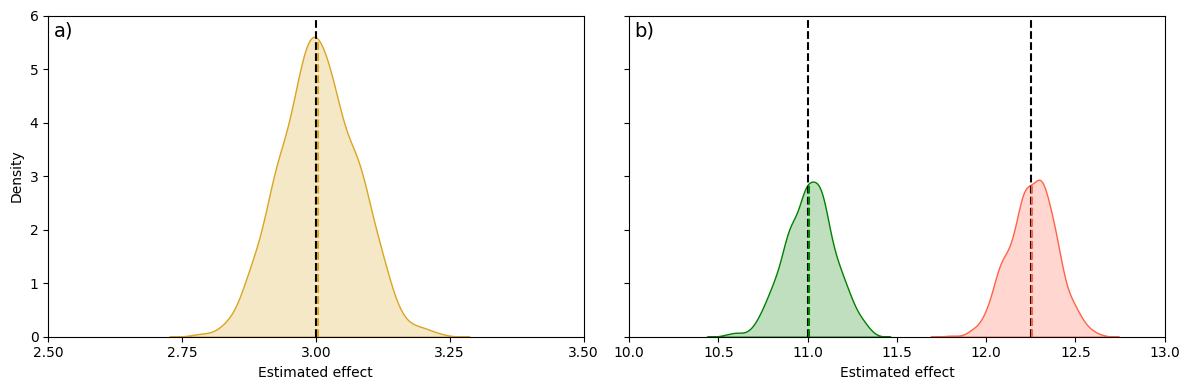

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- First plot ---
ax = axes[0]

ax.axvline(direct_causal_effect, color="black", linestyle="--", label="Direct effect")
sns.kdeplot(coeffs_direct, label="Direct", fill=True, color="goldenrod", ax=ax)
ax.vlines(mean_direct, 0, height_direct, colors="goldenrod", linestyles="--", label="Mean direct")

ax.set_xlim(2.5, 3.5)
ax.set_ylim(0, 6)
ax.set_xticks(np.arange(2.5, 3.75, 0.25))
ax.set_xlabel("Estimated effect")
ax.text(0.01, 0.98, "a)", transform=ax.transAxes,
        fontsize=14, va="top", ha="left")

# --- Second plot ---
ax = axes[1]

ax.axvline(unadjusted_effect, color="black", linestyle="--", label="Unadjusted effect")
sns.kdeplot(coeffs_unadjusted, label="Unadjusted", fill=True, color="tomato", ax=ax)
ax.vlines(mean_unadjusted, 0, height_unadjusted, colors="tomato", linestyles="--", label="Mean unadjusted")

ax.axvline(total_causal_effect, color="black", linestyle="--", label="Total effect")
sns.kdeplot(coeffs_total, label="Total", fill=True, color="green", ax=ax)
ax.vlines(mean_total, 0, height_total, colors="green", linestyles="--", label="Mean total")

ax.set_xlim(10, 13)
ax.set_ylim(0, 6)
ax.set_xticks(np.arange(10, 13.5, 0.5))
ax.set_xlabel("Estimated effect")
ax.set_ylabel("Density")
ax.text(0.01, 0.98, "b)", transform=ax.transAxes,
        fontsize=14, va="top", ha="left")

# Layout
plt.tight_layout()
plt.savefig("estimations_sys_2.svg")


# Simulation 3

Simulation 3 is a simulation of System 3 (see the graph). All functions are linear. This simulation shows the difference between uninformed variable selection, direct variable selection, all variable selection, unadjusted estimation, and SCM. The first estimation uses SCM (the good adjustment set), the three estimation that follow select 3, 7, or 11 random variables (make an uninformed selection). The fifht estimation uses all variables. The sixth estimation uses only direct predictor variables, and the last estimation uses no predictor variables (unadjusted).

- Total causal effect = 3.1144 (see report)
- Direct effect = 3

### DoWhy


In this script, DoWhy is implemented to find the theoretically valid adjustment set that satisfies the backdoor criterion. We use several identification implementations of the back-door identification to show that there are more than one valid adjustement sets. Later, in the estimation, we used the default/minimal adjustment set.

An empty dataframe is created to use with DoWhy.

In [ ]:
df = pd.DataFrame(columns=[
    'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
    'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16',
    'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23',
    'x24', 'T', 'Y'
])

The causal graph is defined for DoWhy with `CausalModel()`.

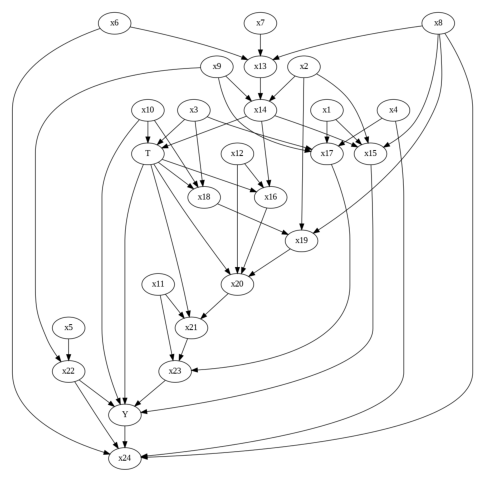

In [ ]:
model = CausalModel(data=df,
                    treatment='T',
                    outcome='Y',
                    graph="""digraph {

                    x6 -> x13;
                    x7 -> x13;
                    x8 -> x13;

                    x13 -> x14;
                    x2 -> x14;
                    x9 -> x14;

                    x14 -> T;
                    x3 -> T;
                    x10 -> T;

                    x14 -> x15;
                    x1 -> x15;
                    x2 -> x15;
                    x8 -> x15;

                    T -> x16;
                    x14 -> x16;
                    x12 -> x16;

                    x1 -> x17;
                    x4 -> x17;
                    x3 -> x17;
                    x9 -> x17;

                    x3 -> x18;
                    T -> x18;
                    x10 -> x18;

                    x2 -> x19;
                    x18 -> x19;
                    x8 -> x19;

                    T -> x20;
                    x16 -> x20;
                    x19 -> x20;
                    x12 -> x20;

                    T -> x21;
                    x20 -> x21;
                    x11 -> x21;

                    x5 -> x22;
                    x9 -> x22;

                    x21 -> x23;
                    x17 -> x23;
                    x11 -> x23;

                    T -> Y;
                    x15 -> Y;
                    x23 -> Y;
                    x22 -> Y;
                    x10 -> Y;

                    Y -> x24;
                    x4 -> x24;
                    x6 -> x24;
                    x22 -> x24;
                    x8 -> x24;

}""")

model.view_model()

Four methods of the back-door identification are used.

In [ ]:
default_estimand = model.identify_effect(method_name='default', proceed_when_unidentifiable=True)
minimal_estimand = model.identify_effect(method_name='minimal-adjustment', proceed_when_unidentifiable=True)
maximal_estimand = model.identify_effect(method_name='maximal-adjustment', proceed_when_unidentifiable=True)
exhaustive_estimand = model.identify_effect(method_name='exhaustive-search', proceed_when_unidentifiable=True)

print('\n')
print('Theoratically valid back-door adjustment sets:\n')
print(f'Default: {default_estimand.get_backdoor_variables()}')
print(f'Minimal: {minimal_estimand.get_backdoor_variables()}')
print(f'Maximal: {maximal_estimand.get_backdoor_variables()}')
print(f'Exhaustive: {exhaustive_estimand.get_backdoor_variables()}')



Theoratically valid back-door adjustment sets:

Default: ['x10', 'x3', 'x14']
Minimal: ['x10', 'x3', 'x14']
Maximal: ['x10', 'x7', 'x13', 'x17', 'x6', 'x15', 'x8', 'x12', 'x4', 'x3', 'x11', 'x1', 'x2', 'x9', 'x22', 'x5', 'x14']
Exhaustive: ['x10', 'x15', 'x4', 'x3', 'x11', 'x5', 'x14']


### Causal graph

The commented code (e.g. `style='invis'`) was used to generate a reduced version for the colloquium.

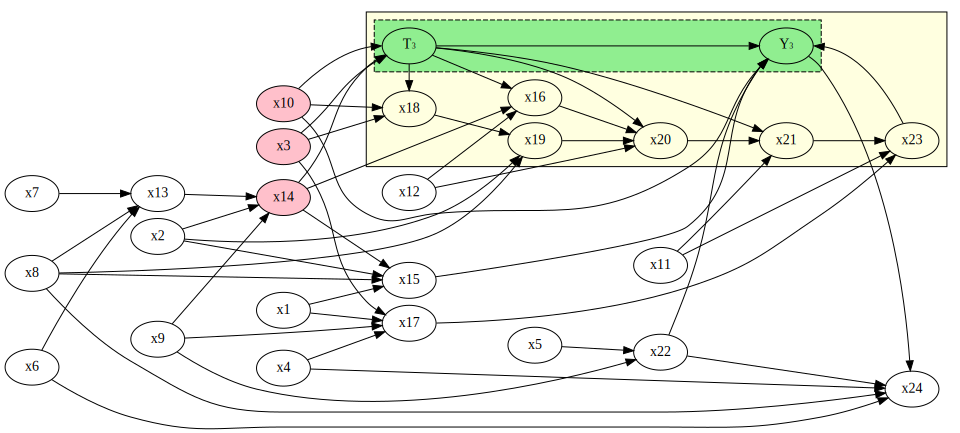

In [37]:
g = gr.Digraph()
g.attr(rankdir='LR', nodesep='0.1', ranksep='1')

# Outer cluster with T, Y, and related nodes
with g.subgraph(name='cluster_TY_outer') as outer:
    outer.attr(
        style='filled',
        color='black',
        fillcolor='lightyellow'
    )

    # Inner cluster with just T and Y
    with outer.subgraph(name='cluster_TY_inner') as inner:
        inner.attr(
            style='filled,dashed',
            color='black',
            fillcolor='lightgreen'
        )
        inner.node('T', label='<T<sub><font point-size="8">3</font></sub>>')
        inner.node('Y', label='<Y<sub><font point-size="8">3</font></sub>>')

    # Additional nodes in outer cluster
    outer.node('x16')
    outer.node('x18')
    outer.node('x19')
    outer.node('x20')
    outer.node('x21')
    outer.node('x23')

# Nodes outside the cluster
g.node('x14', style='filled', fillcolor='pink')
g.node('x10', style='filled', fillcolor='pink')
g.node('x3', style='filled', fillcolor='pink')

# Edges (unchanged)
g.edge('x6', 'x13') # style='invis'
g.edge('x7', 'x13') # style='invis'
g.edge('x8', 'x13')

g.edge('x13', 'x14')
g.edge('x2', 'x14')
g.edge('x9', 'x14')

g.edge('x14', 'T')
g.edge('x3', 'T')
g.edge('x10', 'T', headport='w')

g.edge('x14', 'x15')
g.edge('x1', 'x15') # style='invis'
g.edge('x2', 'x15')
g.edge('x8', 'x15')

g.edge('T', 'x16')
g.edge('x14', 'x16')
g.edge('x12', 'x16') # style='invis'

g.edge('x1', 'x17') # style='invis'
g.edge('x4', 'x17') # style='invis'
g.edge('x3', 'x17')
g.edge('x9', 'x17')

g.edge('x3', 'x18')
g.edge('T', 'x18')
g.edge('x10', 'x18')

g.edge('x2', 'x19')
g.edge('x18', 'x19')
g.edge('x8', 'x19' )

g.edge('T', 'x20')
g.edge('x16', 'x20')
g.edge('x19', 'x20')
g.edge('x12', 'x20') # style='invis'

g.edge('T', 'x21')
g.edge('x20', 'x21')
g.edge('x11', 'x21') # style='invis'

g.edge('x5', 'x22') # style='invis'
g.edge('x9', 'x22')

g.edge('x21', 'x23')
g.edge('x17', 'x23')
g.edge('x11', 'x23') # style='invis'

g.edge('T', 'Y', minlen='3')
g.edge('x15', 'Y')
g.edge('x23', 'Y', headport='e')
g.edge('x22', 'Y')
g.edge('x10', 'Y')

g.edge('Y', 'x24') # style='invis'
g.edge('x4', 'x24') # style='invis'
g.edge('x6', 'x24') # style='invis'
g.edge('x22', 'x24') # style='invis'
g.edge('x8', 'x24') # style='invis'

# g.node('x7', style='invis')
# g.node('x1', style='invis')
# g.node('x4', style='invis')
# g.node('x5', style='invis')
# g.node('x11', style='invis')
# g.node('x6', style='invis')
# g.node('x12', style='invis')
# g.node('x24', style='invis')

# g.node('x2', style='filled', fillcolor='lightgrey')
# g.node('x8', style='filled', fillcolor='lightgrey')
# g.node('x9', style='filled', fillcolor='lightgrey')

g


Save DAG System 3 as SVG file to the environment. From there it can be downloaded.

In [38]:
g.render('system_3', format='svg', cleanup=True)

'system_3.svg'

### Estimations System 3

Initiate parameters

In [39]:
n = 1000
iterations = 1000

total_causal_effect = 3.1144
direct_causal_effect = 3
scale = 0.5

Define a list of parameters that is used for the random variable selection (uninformed decision).

In [40]:
candidate_vars = [
    'x1', 'x2', 'x3', 'x4', 'x5', 'x6',
    'x7', 'x8', 'x9', 'x10', 'x11',
    'x12', 'x13', 'x14', 'x15', 'x16',
    'x17', 'x18', 'x19', 'x20', 'x21',
    'x22', 'x23', 'x24'
]

Lists are initiated. In a `for loop`, the data is generated (`n` samples) and OLS estimations are performed `iterations` times. Mean estimated coefficients are prited and Kernal Density Estimations (KDE) are performed for visualizing the coefficient data.

In [41]:
coeffs_theoretical = []
coeffs_rand_3 = []
coeffs_rand_7 = []
coeffs_rand_11 = []
coeffs_all = []
coeffs_direct_predictor = []
coeffs_no_control = []

for _ in range(iterations):

    # Random variable selection
    random_vars_3 = np.random.choice(candidate_vars, size=3, replace=False)
    random_vars_7 = np.random.choice(candidate_vars, size=7, replace=False)
    random_vars_11 = np.random.choice(candidate_vars, size=11, replace=False)

    # Data generation (exogenous variables)
    x1 = np.random.normal(0, 1, n)
    x2 = np.random.normal(0, 1, n)
    x3 = np.random.normal(0, 1, n)
    x4 = np.random.normal(0, 1, n)
    x5 = np.random.normal(0, 1, n)
    x6 = np.random.normal(0, 1, n)
    x7 = np.random.normal(0, 1, n)
    x8 = np.random.normal(0, 1, n)
    x9 = np.random.normal(0, 1, n)
    x10 = np.random.normal(0, 1, n)
    x11 = np.random.normal(0, 1, n)
    x12 = np.random.normal(0, 1, n)

    # Data generation (endogenous variables)
    x13 = 0.5 * x6 + 0.4 * x7 + 0.2 * x8 + np.random.normal(0, scale, n)
    x14 = 0.6 * x13 + 0.3 * x2 + 0.2 * x9 + np.random.normal(0, scale, n)
    T = 0.5 * x14 + 0.7 * x3 + 0.3 * x10 + np.random.normal(0, scale, n)
    x15 = 0.4 * x14 + 0.5 * x1 + 0.3 * x2 + 0.2 * x8 + np.random.normal(0, scale, n)
    x16 = 0.6 * T + 0.4 * x14 + 0.2 * x12 + np.random.normal(0, scale, n)
    x17 = 0.5 * x1 + 0.4 * x4 + 0.3 * x3 + 0.2 * x9 + np.random.normal(0, scale, n)
    x18 = 0.6 * x3 + 0.5 * T + 0.3 * x10 + np.random.normal(0, scale, n)
    x19 = 0.5 * x2 + 0.6 * x18 + 0.2 * x8 + np.random.normal(0, scale, n)
    x20 = 0.5 * T + 0.3 * x16 + 0.2 * x19 + 0.2 * x12 + np.random.normal(0, scale, n)
    x21 = 0.7 * T + 0.6 * x20 + 0.2 * x11 + np.random.normal(0, scale, n)
    x22 = 0.7 * x5 + 0.3 * x9 + np.random.normal(0, scale, n)
    x23 = 0.5 * x21 + 0.6 * x17 + 0.2 * x11 + np.random.normal(0, scale, n)
    Y = direct_causal_effect * T + 0.3 * x15 + 0.2 * x23 + 0.5 * x22 + 0.4 * x10 + np.random.normal(0, scale, n)
    x24 = 0.3 * Y + 0.4 * x4 + 0.3 * x6 + 0.4 * x22 + 0.3 * x8 + np.random.normal(0, scale, n)

    # Compile DataFrame
    df = pd.DataFrame({
        'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5, 'x6': x6, 'x7': x7, 'x8': x8, 'x9': x9,
        'x10': x10, 'x11': x11, 'x12': x12, 'x13': x13, 'x14': x14, 'x15': x15, 'x16': x16,
        'x17': x17, 'x18': x18, 'x19': x19, 'x20': x20, 'x21': x21, 'x22': x22, 'x23': x23,
        'x24': x24, 'T': T, 'Y': Y
    })

    # OLS estmations
    # Theoretically valid adjustment set
    X = df[['T', 'x14', 'x10', 'x3']] # Good predictors that may also be included (do predict Y, but don't violate the back-dood criterion): 'x15', 'x22'
    X = sm.add_constant(X)

    y = df['Y']
    model_theoretical = sm.OLS(y, X).fit()
    coeffs_theoretical.append(model_theoretical.params['T'])

    # 3 random variables
    X = df[['T'] + list(random_vars_3)]
    X = sm.add_constant(X)

    y = df['Y']
    model_rand_3 = sm.OLS(y, X).fit()
    coeffs_rand_3.append(model_rand_3.params['T'])

    # 7 random variables
    X = df[['T'] + list(random_vars_7)]
    X = sm.add_constant(X)

    y = df['Y']
    model_rand_7 = sm.OLS(y, X).fit()
    coeffs_rand_7.append(model_rand_7.params['T'])

    # 11 random variables
    X = df[['T'] + list(random_vars_11)]
    X = sm.add_constant(X)

    y = df['Y']
    model_rand_11 = sm.OLS(y, X).fit()
    coeffs_rand_11.append(model_rand_11.params['T'])

    # All variables
    X = df[['T'] + list(candidate_vars)]
    X = sm.add_constant(X)

    y = df['Y']
    model_all = sm.OLS(y, X).fit()
    coeffs_all.append(model_all.params['T'])

    # Direct predictors
    X = df[['T', 'x10', 'x15', 'x22', 'x23']]
    X = sm.add_constant(X)

    y = df['Y']
    model_direct_predictor = sm.OLS(y, X).fit()
    coeffs_direct_predictor.append(model_direct_predictor.params['T'])

    # No control
    X = df[['T']]
    X = sm.add_constant(X)

    y = df['Y']
    model_no_control = sm.OLS(y, X).fit()
    coeffs_no_control.append(model_no_control.params['T'])

# Print mean of estiamtions
print(f'Estimated total effect: {np.mean(coeffs_theoretical):.3f} sdev: {np.std(coeffs_theoretical):.3f}','\n')
print(f'Estimated random 3 effect: {np.mean(coeffs_rand_3):.3f} sdev: {np.std(coeffs_rand_3):.3f}','\n')
print(f'Estimated random 7 effect: {np.mean(coeffs_rand_7):.3f} sdev: {np.std(coeffs_rand_7):.3f}','\n')
print(f'Estimated random 11 effect: {np.mean(coeffs_rand_11):.3f} sdev: {np.std(coeffs_rand_11):.3f}','\n')
print(f'Estimated effect all: {np.mean(coeffs_all):.3f} sdev: {np.std(coeffs_all):.3f}','\n')
print(f'Estimated direct predictor effect: {np.mean(coeffs_direct_predictor):.3f} sdev: {np.std(coeffs_direct_predictor):.3f}','\n')
print(f'Estimated unadjusted effect: {np.mean(coeffs_no_control):.3f} sdev: {np.std(coeffs_no_control):.3f}','\n')

# KDEs
kde_theoretical = gaussian_kde(coeffs_theoretical)
kde_rand_3 = gaussian_kde(coeffs_rand_3)
kde_rand_7 = gaussian_kde(coeffs_rand_7)
kde_rand_11 = gaussian_kde(coeffs_rand_11)
kde_all = gaussian_kde(coeffs_all)
kde_direct_predictor = gaussian_kde(coeffs_direct_predictor)
kde_no_control = gaussian_kde(coeffs_no_control)

# Means
mean_theoretical = np.mean(coeffs_theoretical)
mean_rand_3 = np.mean(coeffs_rand_3)
mean_rand_7 = np.mean(coeffs_rand_7)
mean_rand_11 = np.mean(coeffs_rand_11)
mean_all = np.mean(coeffs_all)
mean_direct_predictor = np.mean(coeffs_direct_predictor)
mean_no_control = np.mean(coeffs_no_control)

# Heights at means
height_theoretical = kde_theoretical(mean_theoretical)
height_rand_3 = kde_rand_3(mean_rand_3)
height_rand_7 = kde_rand_7(mean_rand_7)
height_rand_11 = kde_rand_11(mean_rand_11)
height_all = kde_all(mean_all)
height_direct_predictor = kde_direct_predictor(mean_direct_predictor)
height_no_control = kde_no_control(mean_no_control)


Estimated total effect: 3.116 sdev: 0.050 

Estimated random 3 effect: 3.192 sdev: 0.168 

Estimated random 7 effect: 3.053 sdev: 0.212 

Estimated random 11 effect: 2.959 sdev: 0.202 

Estimated effect all: 2.753 sdev: 0.056 

Estimated direct predictor effect: 3.001 sdev: 0.022 

Estimated unadjusted effect: 3.342 sdev: 0.026 



KDEs of System 3 are plotted and saved to SVG file format.

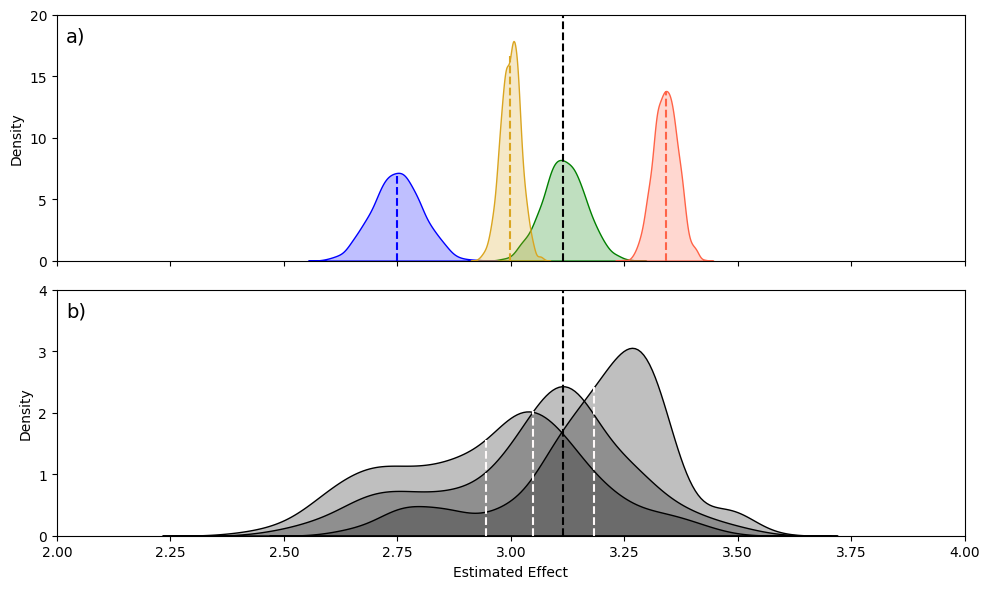

In [ ]:
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Set common x-axis limits
x_min, x_max = 2, 4
x_ticks = np.arange(x_min, x_max + 1, 1)

# --- First plot ---
ax = axes[0]
sns.kdeplot(coeffs_theoretical, fill=True, color="green", ax=ax)
sns.kdeplot(coeffs_all, fill=True, color="blue", ax=ax)
sns.kdeplot(coeffs_direct_predictor, fill=True, color="goldenrod", ax=ax)
sns.kdeplot(coeffs_no_control, fill=True, color="tomato", ax=ax)
ax.axvline(total_causal_effect, color="black", linestyle="--")
ax.vlines(mean_all, 0, height_all, colors="blue", linestyles="--")
ax.vlines(mean_direct_predictor, 0, height_direct_predictor, colors="goldenrod", linestyles="--")
ax.vlines(mean_no_control, 0, height_no_control, colors="tomato", linestyles="--")
ax.set_ylabel("Density")  # Remove individual label
ax.set_yticks(np.arange(0, 21, 5))
ax.text(0.01, 0.95, "a)", transform=ax.transAxes,
        fontsize=14, va="top", ha="left")

# --- Second plot ---
ax = axes[1]
ax.vlines(mean_rand_3, 0, height_rand_3, colors="snow", linestyles="--")
sns.kdeplot(coeffs_rand_3, fill=True, color="black", ax=ax)

ax.vlines(mean_rand_7, 0, height_rand_7, colors="snow", linestyles="--")
sns.kdeplot(coeffs_rand_7, fill=True, color="black", ax=ax)

ax.vlines(mean_rand_11, 0, height_rand_11, colors="snow", linestyles="--")
sns.kdeplot(coeffs_rand_11, fill=True, color="black", ax=ax)

ax.axvline(total_causal_effect, color="black", linestyle="--")
ax.set_xlabel("Estimated Effect")
ax.set_ylabel("Density")  # Remove individual label
ax.set_yticks(np.arange(0, 5))
ax.text(0.01, 0.95, "b)", transform=ax.transAxes,
        fontsize=14, va="top", ha="left")

# Layout
plt.xlim(x_min, x_max)
# plt.legend()
plt.tight_layout()

plt.savefig("estimations_sys_3.svg")


# Presentation

For the presentation/colloquium, I made a new system. This system includes, for ecologists, intuitive variables that make understaning the SCM framwork easier because of the context.

### Causal graph

The commented code (e.g. `style='invis'`) was used to generate a reduced version for the colloquium.

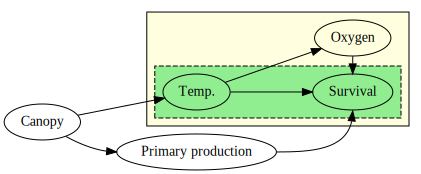

In [ ]:
g = gr.Digraph()
g.attr(rankdir='LR')

# Outer cluster that includes inner cluster + X
with g.subgraph(name='cluster_outer') as outer:
    outer.attr(
        style='filled',
        color='black',
        fillcolor='lightyellow'
    )

    # Inner cluster with T and Y
    with outer.subgraph(name='cluster_TY') as inner:
        inner.attr(
            style='filled,dashed',
            color='black',
            fillcolor='lightgreen'
        )
        inner.node('Temp.')
        inner.node('Survival')

    # X is part of the outer cluster but not the inner
    outer.node('Oxygen')

# Add other nodes and edges
g.edge("Temp.", "Survival")
g.edge("Temp.", "Oxygen")
g.edge("Oxygen", "Survival")
g.edge("Canopy", "Temp.")                                             # style="invis"
g.edge("Canopy", "Primary production", headport='w')                  # style="invis"
g.edge("Primary production", "Survival", tailport="e", headport='s')  # style="invis"
# g.node("Canopy", style="invis")
# g.node("Primary production", style="invis")

g


Save DAG Presentation System as SVG file to the environment. From there it can be downloaded.

In [ ]:
g.render('pres_sys_1', format='svg', cleanup=True)

'pres_sys_1.svg'

### Estimations Presentation System



Initiate parameters

In [ ]:
n = 1000
iterations = 1000

total_causal_effect = 11
direct_causal_effect = 3
unadjusted_effect = 9.125

Lists are initiated. In a `for loop`, the data is generated (`n` samples) and OLS estimations are performed `iterations` times. Mean estimated coefficients are prited and Kernal Density Estimations (KDE) are performed for visualizing the coefficient data.

In [ ]:
# Initiate lists
coeffs_total = []
coeffs_direct = []
coeffs_unadjusted = []

# Loop data generation and OLS estimation
for _ in range(iterations):

    # Canopy
    canopy = np.random.rand(n)

    # Temperature depends on Canopy
    temp = -1*canopy + np.random.normal(0, 0.5, n)

    # Oxygen depends on Temperature
    oxygen = 2*temp + np.random.normal(0, 0.5, n)

    # Primary production depends on Canopy
    primary = -1.5*canopy + np.random.normal(0, 0.5, n)

    # Survival depends on T, X, P
    survival = direct_causal_effect * temp + 4*oxygen - 5*primary + np.random.normal(0, 0.5, n)

    df = pd.DataFrame({'canopy': canopy,
                       'temp': temp,
                       'oxygen': oxygen,
                       'primary': primary,
                       'survival': survival})

    # Unadjusted model: regress Y ~ T
    Z_unadjusted = sm.add_constant(df[['temp']])
    model_unadjusted = sm.OLS(df['survival'], Z_unadjusted).fit()
    coeffs_unadjusted.append(model_unadjusted.params['temp'])

    # Direct effect model: regress Y ~ T + X + P + C
    Z_direct = sm.add_constant(df[['temp', 'oxygen', 'primary']]) # , 'canopy'
    model_direct = sm.OLS(df['survival'], Z_direct).fit()
    coeffs_direct.append(model_direct.params['temp'])

    # Total effect model: regress Y ~ T + C
    Z_total = sm.add_constant(df[['temp', 'canopy']])
    model_total = sm.OLS(df['survival'], Z_total).fit()
    coeffs_total.append(model_total.params['temp'])

# Print means and SDs of estimations
print(f'Estimated total effect: {np.mean(coeffs_total):.3f} sdev: {np.std(coeffs_total):.3f}\n')
print(f'Estimated direct effect: {np.mean(coeffs_direct):.3f} sdev: {np.std(coeffs_direct):.3f}\n')
print(f'Estimated unadjusted effect: {np.mean(coeffs_unadjusted):.3f} sdev: {np.std(coeffs_unadjusted):.3f}\n')

# Estimate kernel densities (KDE)
kde_total = gaussian_kde(coeffs_total)
kde_direct = gaussian_kde(coeffs_direct)
kde_unadjusted = gaussian_kde(coeffs_unadjusted)

# Calculate mean estimated coefficient
mean_total = np.mean(coeffs_total)
mean_direct = np.mean(coeffs_direct)
mean_unadjusted = np.mean(coeffs_unadjusted)

# Get density height at mean estimated coefficient
height_total = kde_total(mean_total)
height_direct = kde_direct(mean_direct)
height_unadjusted = kde_unadjusted(mean_unadjusted)


Estimated total effect: 11.010 sdev: 0.205

Estimated direct effect: 3.003 sdev: 0.071

Estimated unadjusted effect: 9.135 sdev: 0.198



KDEs of Presentation System are plotted and saved to SVG file format.

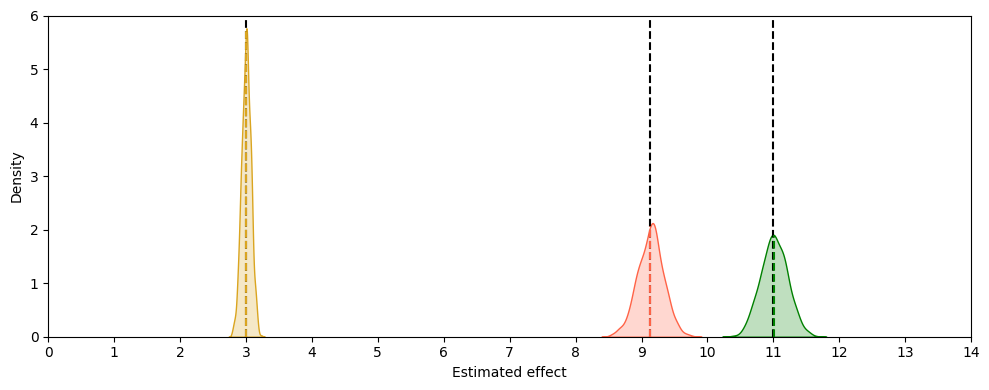

In [ ]:
plt.figure(figsize=(10, 4))

# Add lines for validated effects
plt.axvline(unadjusted_effect, color="black", linestyle="--", label="Unadjusted effect")
plt.axvline(direct_causal_effect, color="black", linestyle="--", label="Direct effect")
plt.axvline(total_causal_effect, color="black", linestyle="--", label="Total effect")

# Plot densities
sns.kdeplot(coeffs_unadjusted, label="Unadjusted", fill=True, color="tomato")
plt.vlines(mean_unadjusted, 0, height_unadjusted, colors="tomato", linestyles="--", label="Mean unadjusted")

sns.kdeplot(coeffs_direct, label="Direct", fill=True, color="goldenrod")
plt.vlines(mean_direct, 0, height_direct, colors="goldenrod", linestyles="--", label="Mean direct")

sns.kdeplot(coeffs_total, label="Total", fill=True, color="green")
plt.vlines(mean_total, 0, height_total, colors="green", linestyles="--", label="Mean total")

# Layout
plt.ylim(0, 6)
plt.xlim(0, 14)
plt.xticks(np.arange(0, 15, 1))
plt.xlabel("Estimated effect")
plt.ylabel("Density")
# plt.legend()
plt.tight_layout()

plt.savefig("4_all.svg")
